In [2]:
import pandas as pd
import os
from pandas import DataFrame
from pandas import concat
from sklearn import preprocessing
import numpy

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('scale%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('scale%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('scale%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

dataset = pd.read_csv('C:/Users/user/datafiles/input_data/data0102-1.csv', header=0, index_col=0)
values = dataset.values
Features = values
minmax_scale = preprocessing.MinMaxScaler(feature_range=(-1,1))
scaleFeature = minmax_scale.fit_transform(Features)
reframed = series_to_supervised(scaleFeature, 24, 1)
reframed.drop(reframed.columns[[6,13,20,27,34,41,48,55,62,69,76,83,90,97,104,111,118,125,132,139,146,153,160,167]], axis=1, inplace=True)
print(reframed.head())

    scale1(t-24)  scale2(t-24)  scale3(t-24)  scale4(t-24)  scale5(t-24)  \
24     -0.119982     -0.084092      0.102556      0.125017     -0.061387   
25      0.250202     -0.024460      0.063310      0.057755      0.014176   
26     -0.054643     -0.086076     -0.019669      0.137835      0.012222   
27     -0.034379     -0.027207      0.011185      0.123430      0.157122   
28      0.011490     -0.013718      0.075456     -0.083604      0.177630   

    scale6(t-24)  scale1(t-23)  scale2(t-23)  scale3(t-23)  scale4(t-23)  \
24      0.507347      0.250202     -0.024460      0.063310      0.057755   
25      0.463645     -0.054643     -0.086076     -0.019669      0.137835   
26      0.488914     -0.034379     -0.027207      0.011185      0.123430   
27      0.424582      0.011490     -0.013718      0.075456     -0.083604   
28      0.496727      0.041917     -0.007919      0.080034      0.172503   

      ...      scale4(t-1)  scale5(t-1)  scale6(t-1)  scale1(t)  scale2(t)  \
24    ..

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
msk = numpy.random.rand(len(reframed)) < 0.8
train_df = reframed[msk]
test_df = reframed[~msk]

train_X, train_y = train_df.values[:, 0:-1], train_df.values[:, -1]
test_X, test_y = test_df.values[:, 0:-1], test_df.values[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14321, 1, 150) (14321,) (3522, 1, 150) (3522,)


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN, LSTM

Using TensorFlow backend.


In [6]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1],train_X.shape[2]), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1))
model.summary()

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
train_history = model.fit(train_X , train_y, validation_data=(test_X, test_y), batch_size=25,
                          shuffle=True,epochs=10, verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               25100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 208,397
Trainable params: 208,397
Non-trainable params: 0
_________________________________________________________________


In [11]:
scores = model.evaluate(test_X, test_y)
scores[1]

3483/3483 [==============================] - 0s 79us/step


0.82314097042779211

In [12]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

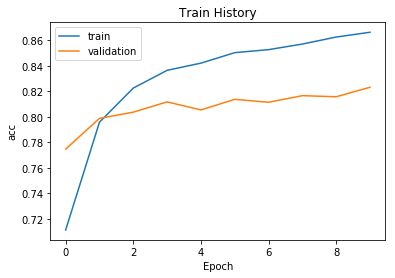

In [13]:
show_train_history(train_history, 'acc', 'val_acc')

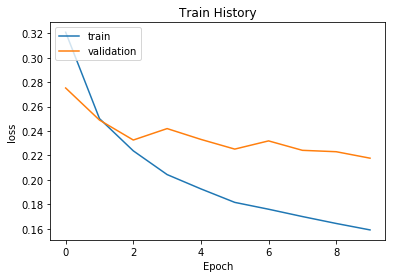

In [14]:
show_train_history(train_history, 'loss', 'val_loss')